In [57]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

!pip install apyori
from apyori import apriori

In [58]:
df = pd.read_csv('afterPreprocess.csv')
df.head()

,Reference Number,Grid Ref: Easting,Grid Ref: Northing,Number of Vehicles,Accident Date,Time (24hr),1st Road Class,1st Road Class & No,Road Surface,Lighting Conditions,Weather Conditions,Local Authority,Type of Vehicle,Casualty Class,Casualty Severity,Sex of Casualty,Age of Casualty
0,5110577,430660,430766,1,2018-01-01,03:44:00,Unclassified,U,Wet / Damp,Darkness: street lights present and lit,Fine without high winds,E08000035,Car,Vehicle or pillion passenger,Slight,Male,23
1,5110577,430660,430766,1,2018-01-01,03:44:00,Unclassified,U,Wet / Damp,Darkness: street lights present and lit,Fine without high winds,E08000035,Car,Driver or rider,Slight,Male,23
2,5110577,430660,430766,1,2018-01-01,03:44:00,Unclassified,U,Wet / Damp,Darkness: street lights present and lit,Fine without high winds,E08000035,Car,Vehicle or pillion passenger,Serious,Male,33
3,5111304,431442,432717,2,2018-01-01,13:35:00,A,A63,Dry,Daylight: street lights present,Fine without high winds,E08000035,Car,Driver or rider,Slight,Female,57
4,5111365,429509,431308,2,2018-01-01,14:21:00,Unclassified,U,Wet / Damp,Daylight: street lights present,Raining without high winds,E08000035,Car,Vehicle or pillion passenger,Slight,Male,18


In [59]:
# hàm bổ trợ
def makeXAxis(start, step, end):
  x_axis = []
  pre = start
  while True:
    next = pre + step
    if next > end:
      next = end
    x_axis.append((pre, next))
    pre += step
    if pre >= end:
      break
  return x_axis

def makeYAxis(s, x_axis):
  y_axis_values = {}
  for i in x_axis:
    y_axis_values[i] = []

  for i in s:
    for j in x_axis:
      if j[1] == x_axis[-1][1]:
        if i >= j[0] and i <= j[1]:
          y_axis_values[j].append(i)
      elif i >= j[0] and i < j[1]:
        y_axis_values[j].append(i)

  y_axis = []
  for i in x_axis:
    y_axis.append(len(y_axis_values[i]))
  return y_axis

def draw(x_axis, y_axis, title, x_label, y_label, size, rotation=45, barh=False):
  plt.figure(figsize=size)
  plt.xticks(rotation = rotation)
  if barh:
      plt.barh([str(i) for i in x_axis], y_axis)
  else:
      plt.bar([str(i) for i in x_axis], y_axis)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.title(title)
#   plt.show()

# Tìm tập phổ biến bằng thuật toán Apriori

In [60]:
df.head(1)

,Reference Number,Grid Ref: Easting,Grid Ref: Northing,Number of Vehicles,Accident Date,Time (24hr),1st Road Class,1st Road Class & No,Road Surface,Lighting Conditions,Weather Conditions,Local Authority,Type of Vehicle,Casualty Class,Casualty Severity,Sex of Casualty,Age of Casualty
0,5110577,430660,430766,1,2018-01-01,03:44:00,Unclassified,U,Wet / Damp,Darkness: street lights present and lit,Fine without high winds,E08000035,Car,Vehicle or pillion passenger,Slight,Male,23


In [67]:
# roi rac hoa thoi gian
def getTime(x, x_axis):
    for i in x_axis:
        if x >= i[0] and x < i[1]:
            return i

# loại bỏ các thuộc tính có nhiều giá trị trùng, thuộc tính về toạ độ, tên đường, ngày, giờ
anotherDf = df.drop(['Local Authority', 'Reference Number', 'Grid Ref: Easting', 'Grid Ref: Northing', '1st Road Class & No', 'Accident Date'], axis=1)

# rời rạc hoá Age + convert sang str
anotherDf['Age of Casualty'] = pd.cut(anotherDf['Age of Casualty'], bins = 5, right=False)
anotherDf['Age of Casualty'] = anotherDf['Age of Casualty'].astype(str)

# rời rạcc hoáá Timee(24h)
anotherDf['Time (24hr)'] = anotherDf['Time (24hr)'].apply(lambda x: x[:2]).astype(int)
anotherDf['Time (24hr)'] = anotherDf['Time (24hr)'].apply(getTime, args=(makeXAxis(0,3,23),)).astype(str)

anotherDf.head()

,Number of Vehicles,Time (24hr),1st Road Class,Road Surface,Lighting Conditions,Weather Conditions,Type of Vehicle,Casualty Class,Casualty Severity,Sex of Casualty,Age of Casualty
0,1,"(3, 6)",Unclassified,Wet / Damp,Darkness: street lights present and lit,Fine without high winds,Car,Vehicle or pillion passenger,Slight,Male,"[19.8, 38.6)"
1,1,"(3, 6)",Unclassified,Wet / Damp,Darkness: street lights present and lit,Fine without high winds,Car,Driver or rider,Slight,Male,"[19.8, 38.6)"
2,1,"(3, 6)",Unclassified,Wet / Damp,Darkness: street lights present and lit,Fine without high winds,Car,Vehicle or pillion passenger,Serious,Male,"[19.8, 38.6)"
3,2,"(12, 15)",A,Dry,Daylight: street lights present,Fine without high winds,Car,Driver or rider,Slight,Female,"[38.6, 57.4)"
4,2,"(12, 15)",Unclassified,Wet / Damp,Daylight: street lights present,Raining without high winds,Car,Vehicle or pillion passenger,Slight,Male,"[1.0, 19.8)"


In [68]:
# hàm bổ trợ
# col_values is a dict, col_values[value] = attribute
def getColValues(df):
    col_values = {}
    for col in df.columns:
        values = df[col].value_counts().index.astype(str)
        for value in values:
            col_values[value] = col
    return col_values

col_values = getColValues(anotherDf)

# counts is a dict, contains combination of value in attributes
# itemSet is a freqItemSet (output of apriori or something else)
def countValues(df, col_values, itemSet):
    cols = []
    df['tmp'] = ''
    for item in itemSet:
        colName = col_values[item]
        cols.append(colName)
        tmp = df[colName].astype(str)
        if df['tmp'][0] == '':
            df['tmp'] += tmp
        else:
            df['tmp'] = df['tmp'] + ' & ' + tmp

    counts = df['tmp'].value_counts().to_dict()
    df.drop(['tmp'], axis=1, inplace=True)
    return counts, cols

In [69]:
# from mlxtend.preprocessing import TransactionEncoder
# from mlxtend.frequent_patterns import apriori

def getTransactions(df):
    transactions = []
    for i in range(0, df.shape[0]):
        tmp = []
        try:
            tmp = set([str(df.values[i, j]) for j in range(df.shape[1])])
            tmp.remove('nan')
            tmp = list(tmp)
        except:
            tmp = [str(df.values[i, j]) for j in range(df.shape[1])]
        transactions.append(tmp)

    # te = TransactionEncoder()
    # te_ary = te.fit(transactions).transform(transactions)
    # df_transactions = pd.DataFrame(te_ary, columns=te.columns_)
    # return df_transactions
    return transactions

def getFrequentItemsets(df, minSupp):
    transactions = getTransactions(df)
    # frequent_itemsets = apriori(transactions, min_support=minSupp, use_colnames=True)
    # frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))

    frequent_itemsets = pd.DataFrame(apriori(transactions, min_support = minSupp))
    return frequent_itemsets

freqItemsets = getFrequentItemsets(anotherDf, 0.5)
freqItemsets

,items,support,ordered_statistics
0,(2),0.614872,"[((), (2), 0.6148717948717949, 1.0)]"
1,(Car),0.654615,"[((), (Car), 0.6546153846153846, 1.0)]"
2,(Daylight: street lights present),0.725641,"[((), (Daylight: street lights present), 0.725..."
3,(Driver or rider),0.603846,"[((), (Driver or rider), 0.6038461538461538, 1..."
4,(Dry),0.739744,"[((), (Dry), 0.7397435897435898, 1.0)]"
5,(Fine without high winds),0.869231,"[((), (Fine without high winds), 0.86923076923..."
6,(Male),0.595897,"[((), (Male), 0.5958974358974359, 1.0)]"
7,(Slight),0.822564,"[((), (Slight), 0.8225641025641026, 1.0)]"
8,(Unclassified),0.530256,"[((), (Unclassified), 0.5302564102564102, 1.0)]"
9,"(2, Fine without high winds)",0.537692,"[((), (2, Fine without high winds), 0.53769230..."


- Thực hiện phân tích mô tả, ta tiến hành rút trích các đặc trưng từ 25 tập phổ biến trên. Các đặc trưng thường xoay quanh mức độ nặng nhẹ của vụ tai nạn hoặc mức độ phổ biến của đặc trưng
    1. Itemset 1, 2, 4 và 5: Các vụ tai nạn thường:
        - Do ô tô gây ra (supp=0.65)
        - Điều kiện ánh sáng: Buổi sáng, có đèn đường (supp=0.73)
        - Tình trạng thời tiết thường là ổn định, không có gió to (supp=0.87)
        - Tình trạng mặt đường thường là khô ráo (supp=0.74)
        - Các điều kiện bên trên là điều kiện thuận lợi cho giao thông. Do đó, có thể kết luận rằng tai nạn xảy ra, phần đa là do yếu tố người điều khiển phương tiện
    2. Itemset 12: Các vụ tai nạn ô tô thường là nhẹ (supp=0.57, conf=0.86)
    3. Itemset 23: Nếu tình trạng thời tiết ổn định (và không có gió to) và điều kiện buổi sáng, có đèn đường thì các vụ tai nạn xảy ra với mức độ nhẹ (supp=0.55, conf=0.83)
    4. Itemset 24: Nếu tình trạng thời tiết ổn định (và không có gió to) và tình trạng mặt đường khô ráo thì các vụ tai nạn xảy ra với mức độ nhẹ (supp=0.58, conf=0.83)

## Phân tích mô tả



### Vị trí các vụ tai nạn

### Xu hướng về số lượng tai nạn giao thông theo thời gian

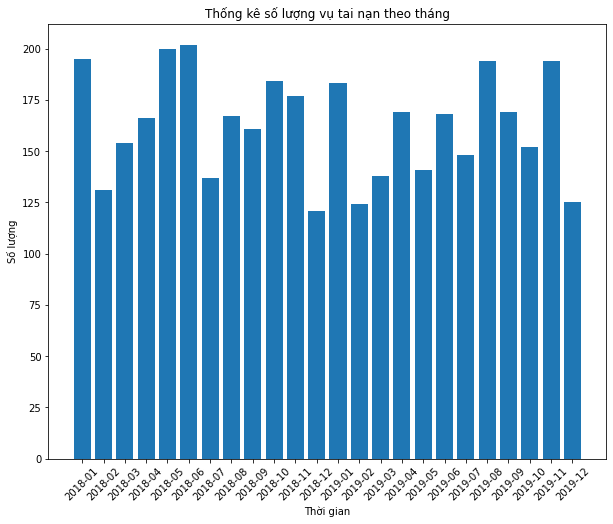

In [94]:
dateCount = df['Accident Date'].apply(lambda x: x[:-3]).value_counts().sort_index()
draw(dateCount.index, dateCount.values, 'Thống kê số lượng vụ tai nạn theo tháng', 'Thời gian', 'Số lượng', (10,8), rotation=45)

- Từ năm 2018 đến 2019, số lượng vụ tai nạn giao thông có xu hướng dữ nguyên. Đối với từng năm, có một vài khoảng thời gian làm cho tai nạn giao thông tăng lên so với bình thường
	- Tháng 1: Đây thời gian diễn ra Tết dương lịch, số lượng người đi du lịch hoặc đi thăm bạn bè, họ hàng sẽ tăng lên. Do đó số vụ tai nạn giao thông cũng tăng theo
	- Từ tháng 3 đến tháng 6 là khoảng thời gian hè, mọi người có xu hướng đi du lịch. Do đó số lượng vụ tai nạn giao thông tăng dần trong khoảng thời gian này, đỉnh điểm là tháng 6, khi thời tiết trở nên nóng bức nhất.
	- Tháng 10, 11: Đây là nơi diễn ra 2 ngày lễ lớn của UK là Quốc Khánh và Lễ Tạ ơn, người ta có xu hướng sẽ đi du lịch hoặc trở về từ thành phố cùng gia đình. Do đó số lượng tai nạn tăng lên.

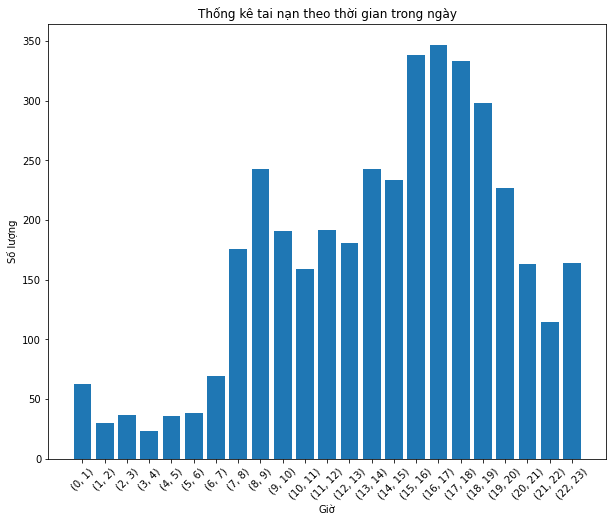

In [73]:
x_axis = makeXAxis(0,1,23)
y_axis = makeYAxis(df['Time (24hr)'].apply(lambda x: x[:2]).astype(int), x_axis)
draw(x_axis, y_axis, 'Thống kê tai nạn theo thời gian trong ngày', 'Giờ', 'Số lượng',(10,8),rotation=45)

- Khoảng thời gian cao điểm của tai nạn giao thông trong ngày rơi vào từ 7 giờ đến 20 giờ. Có thể chia ra làm 2 khoảng cao điểm chính:
	- Từ 7h đến 10h: Khoảng thời gian bắt đầu đi làm, đỉnh điểm rơi vào 1 tiếng đồng hồ từ 8h đến 9h.
	- Từ 15h đến 19h: Khoảng thời gian tan làm, đỉnh điểm rơi vào 1 tiếng đồng hồ từ 16h đến 17h.
Trong khoảng thời gian này, số vụ tai nạn chiếm gần 10% tổng số vụ tai nạn xảy ra trong 2 năm.
- Do đó, cần chú ý khi tham gia giao thông vào giờ cao điểm.

### Liên hệ giữa độ tuổi, giới tính và mức độ nghiêm trọng của tai nạn

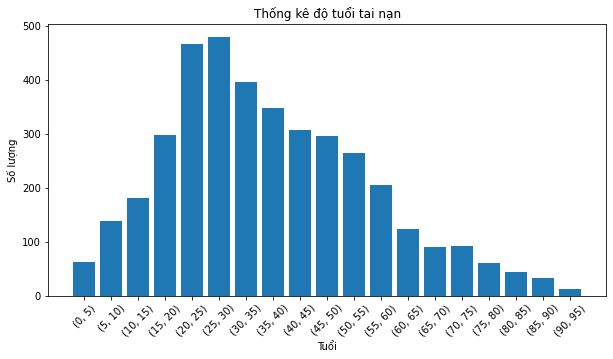

In [89]:
x_axis = makeXAxis(start=0, step=5, end=np.max(df['Age of Casualty']))
y_axis = makeYAxis(df['Age of Casualty'],x_axis)
draw(x_axis, y_axis, 'Thống kê độ tuổi tai nạn', 'Tuổi', 'Số lượng', (10,5))

- Quan sát biểu đồ trên, ta thấy độ tuổi gây tai nạn nhiều nhất là từ 20 đến 40 tuổi.
- Tiếp tục khảo sát yếu tố độ tuổi với các yếu tố khác.

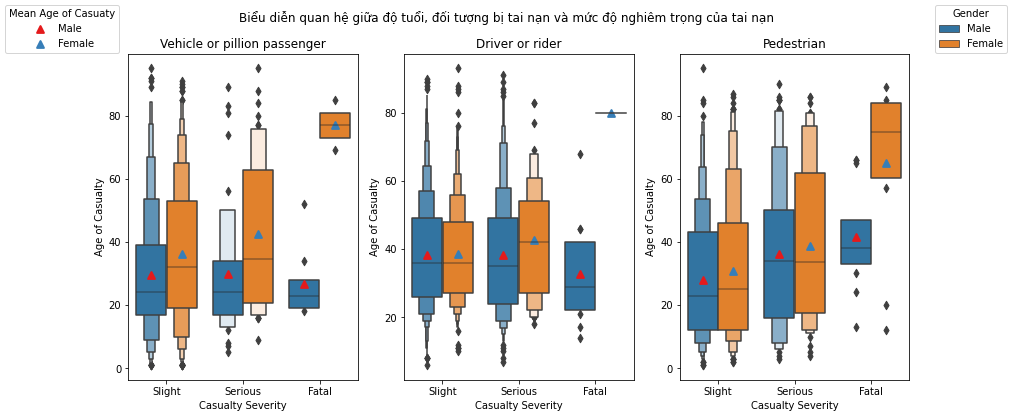

In [93]:
casualty_class = df['Casualty Class'].unique()

fig, axes = plt.subplots(1, 3, figsize=(14, 6))
fig.suptitle('Biểu diễn quan hệ giữa độ tuổi, đối tượng bị tai nạn và mức độ nghiêm trọng của tai nạn')
for i in range(len(casualty_class)):
    data_df = df[df['Casualty Class'] == casualty_class[i]]
    sns.boxenplot(data=data_df, x='Casualty Severity', y='Age of Casualty', hue='Sex of Casualty', ax=axes[i])
    sns.pointplot(data=data_df, x='Casualty Severity', y='Age of Casualty', hue='Sex of Casualty',
                  linestyles='None', errwidth=0, dodge=0.4, markers=['^', '^'], palette='Set1', ax=axes[i])
    
    axes[i].get_legend().remove()
    axes[i].set_title(casualty_class[i])

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles[:2], labels[:2], title='Gender')
fig.legend(handles[2:], labels[2:], title='Mean Age of Casuaty', loc='upper left')

plt.show()

- Quan sát cả 2 biểu đồ trên, có thể kết luận rằng
    - Độ tuổi dễ gây tai nạn giao động từ 15 đến 50.
    - Độ tuổi gây tai nạn trung bình của nam luôn thấp hơn nữ.
    - Trong đó
        - Đối với đối tượng tai nạn là hành khách đi cùng, nữ chiếm đa số. Do điều kiện sức khoẻ cũng như khả năng phản ứng của nữ thường thấp hơn nam nên số ca nữ thường nhiều hơn.
        - Đối với đối tượng tai nạn là người điều khiển phương tiện, nam chiếm đa số; số ca tử vong của nam (chỉ xuất hiện ở độ tuổi từ 20-40) gấp nhiều lần số lượng nữ (chỉ xuất hiện ở độ tuổi 80). Dễ thấy ở nam giới, độ tuổi này thường có cuộc sống vội vã. Do đó, cần chú ý hơn khi tham gia giao thông.
        - Đối với người đi bộ, số ca tử vong của nữ gần như gấp 2 lần số ca tử vong của nam, độ tuổi tai nạn của nữ giới giao động từ 60 trở lên. Do đó, đối tượng nữ là người già cần phải chú ý khi tham gia giao thông hoặc khi ra đường, cần có người bảo hộ đi cùng.
    - Đặc biệt, đối với đối tượng tai nạn là người điều khiển phương tiện, xuất hiện các ca tử vong ở nam giới tầm 12 tuổi và các ca nghiêm trọng ở nam giới trong tầm dưới 10 tuổi. Phụ huynh cần chú ý đến hành vi của trẻ trong độ tuổi này để tránh tai nạn đáng tiếc.

### Liên hệ giữa loại đường, điều kiện sáng với mức độ nghiêm trọng

In [ ]:
anotherDf['Casualty Severity'].value_counts()

In [ ]:
light_conditions = anotherDf['Lighting Conditions'].unique()
figrows = 3; figcols = 2

fig, axes = plt.subplots(figrows, figcols, figsize=(15, 14))
fig.tight_layout()
fig.subplots_adjust(hspace=0.2, wspace=0.2)
for i in range(len(anotherDf['Road Surface'].unique())):
    sns.countplot(data=anotherDf[anotherDf['Lighting Conditions'] == light_conditions[i]], x='1st Road Class',
                 hue='Casualty Severity', ax=axes[i // figcols, i % figcols])
    axes[i // figcols, i % figcols].get_legend().remove()
    axes[i // figcols, i % figcols].set_title(light_conditions[i])
    axes[i // figcols, i % figcols].set_xticklabels(anotherDf['1st Road Class'].unique())
    
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels)
fig.delaxes(axes[-1, -1])

- Biểu đồ trên khảo sát mức độ nghiêm trọng của các vụ tai nạn xảy ra trên các loại đường dựa theo điều kiện ánh sáng
- Quan sát biểu đồ, ta có được một vài đặc trưng sau
    - Đối với đường 'Unclassified', 